# Notes

- There are two sets for this, one from a [2014 publication](https://doi.org/10.1016/j.cub.2014.09.072), one from a [2016 publication](https://elifesciences.org/articles/16965)
- The 2016 publication data contains 4 mutations at 3 subsequent and 1 "far off" sites. There's no real "target value" that can be extrapolated, as such, the focus is on parsing the data from the 2014 publicaiton.

#### First idea (discarted!)
- For the 2014 publication, the data is in the supplements of the manuscript. At the time of writing this, the link was: https://www.cell.com/cms/10.1016/j.cub.2014.09.072/attachment/3a36211d-bddd-43e3-bf42-a6721f93a18b/mmc2.xlsx
- The XLS contains one sheet with double, single and WT reads. Parsing the RAW excel in pandas ain't an option, so I copy pasted the relevant tables in separate sheets of the original excel file
- In the excel, the fittness for single mutations is weirdly duplicated in the double mutations and not expressed in the single mutations counts. As such, I will extract all data from the double counts after some verification


#### Second idea
- After a brief sanity check, the data in the excel file was inconsistent. E.g., as possible amino acid positions, it listead floating point values:
  ```
  [in]  list(map(lambda x: print(x), doubles['Mut1 Position'].unique()))
  
  [out] 2
        3
        4
        Mut1 Position
        4.61002624942922
        4.61020016743552
        ...
  ```
- After doing some digging, it seems there's a repo available by the second author (first of the 2016 print): https://github.com/wchnicholas/DoubleMutFit2DDG
- This repo is linked to another [2015 paper](https://onlinelibrary.wiley.com/doi/full/10.1002/pro.2840), which computes ΔΔG not as a function of a library.
- After further digging, a csv-like formatted set of single and double mutations is available here: https://github.com/wchnicholas/DoubleMutFit2DDG/tree/master/result
- From here, one has to compute the fittness scores by hand for singles and doubles.
- Based on Fig 1 fitness is computed as `SelectionCount(WT) + SelectionCount(Mut) / InputCount(WT) + InputCount(Mut)`
- WT counts are:
  ```
        InputCount    SelectionCount(SumOfTriplicates)
    WT	1759616	      3041819
  ```

In [2]:
from pathlib import Path

from pandas import read_csv

In [3]:
data_path = Path('') / '..' / 'data' / 'gb1'
task_path = Path('') / '..' / 'tasks' / 'gb1'

In [4]:
singles_path = data_path / 'SingleSub.txt'
doubles_path = data_path / 'DoubleSub.txt'

In [5]:
singles = read_csv(singles_path, sep="\t")

In [32]:
singles[:3]

,Substitution-WTaa,Substitution-Pos,Substitution-Mutaa,InputCount,SelectionCount(SumOfTriplicates)
0,T,16,R,106367,184675
1,T,16,S,71248,69455
2,T,16,P,90794,66331


In [22]:
sequence_positions = singles[['Substitution-WTaa', 'Substitution-Pos']].drop_duplicates().sort_values(by="Substitution-Pos")

In [23]:
reference_region = "".join(sequence_positions["Substitution-WTaa"].values)

In [24]:
print(reference_region)

QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE


This sequence has 100% identity and coverage to: https://www.ncbi.nlm.nih.gov/protein/5LDE_A?report=genbank&log$=protalign&blast_rank=1&RID=H7XZK6PV016, which is a PDB structure. It starts at UniProt pos 2 and ends at pos 56. As "whole sequences" are preferred (protein LMs trained on those, usually), I extract the FASTA:

```
>pdb|5LDE|A Chain A, Immunoglobulin G-binding protein G,Viral FLICE protein
MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTELEVLFQGPLDPNSM
ATYEVLCEVARKLGTDDREVVLFLLNVFIPQPTLAQLIGALRALKEEGRLTFPLLAECLFRAGRRDLLRD
LLHLDPRFLERHLAGTMSYFSPYQLTVLHVDGELCARDIRSLIFLSKDTIGSRSTPQTFLHWVYCMENLD
LLGPTDVDALMSMLRSLSRVDLQRQVQTLMGLHLSGPSHSQHYRHTPLEHHHHHH
```

This further led to the discovery of [P06654](https://www.uniprot.org/uniprot/P06654/:

```
>sp|P06654|SPG1_STRSG Immunoglobulin G-binding protein G OS=Streptococcus sp. group G OX=1320 GN=spg PE=1 SV=1
MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRNGGELTNLLGNSETT
LALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGV
SDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELA
EAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDTYKLILNGKTLKG
ETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYK
LVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGD
APTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTTGEG
SNPFFTAAALAVMAGAGALAVASKRKED
```

However, in the UniProt sequence, the start (298) is a T instead of a Q. I'll thus pick the PDB sequence

In [30]:
reference_sequence = """
MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTELEVLFQGPLDPNSM
ATYEVLCEVARKLGTDDREVVLFLLNVFIPQPTLAQLIGALRALKEEGRLTFPLLAECLFRAGRRDLLRD
LLHLDPRFLERHLAGTMSYFSPYQLTVLHVDGELCARDIRSLIFLSKDTIGSRSTPQTFLHWVYCMENLD
LLGPTDVDALMSMLRSLSRVDLQRQVQTLMGLHLSGPSHSQHYRHTPLEHHHHHH
""".replace("\n", "")

region = (2,56)

In [31]:
assert(reference_sequence[region[0]-1:region[1]] == reference_region)

In [36]:
# SelectionCount(WT) + SelectionCount(Mut) / InputCount(WT) + InputCount(Mut)

WT = {
    'input_count': 1759616,
    'selection_count': 3041819
}

def get_fittness(row):
    return (
        (row['SelectionCount(SumOfTriplicates)'] + WT['selection_count']) / 
        (row['InputCount'] + WT['input_count'])
    )

In [40]:
singles['fittness'] = singles.apply(get_fittness, axis=1)

<AxesSubplot:>

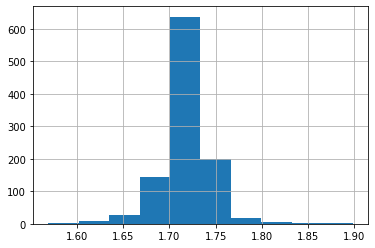

In [46]:
singles.fittness.hist()

In [33]:
doubles = read_csv(doubles_path, sep="\t")

In [34]:
doubles[:3]

,Substitution1-WTaa,Substitution1-Pos,Substitution1-Mutaa,Substitution2-WTaa,Substitution2-Pos,Substitution2-Mutaa,InputCount,SelectionCount(SumOfTriplicates),ExpectedFit,Sub1fit,Sub2fit
0,K,31,R,T,53,K,566,190,0.223,0.234,0.953
1,K,31,R,T,53,I,167,47,0.177,0.234,0.759
2,K,31,R,T,53,H,345,72,0.158,0.234,0.678
